# Notebook to Preprocess MIMIC-III v1.4 Data Files

In this notebook we will preprocess the [MIMIC-III](https://physionet.org/content/mimiciii/1.4/) v1.4 data files as extracted by [MIMIC-Code](https://github.com/MIT-LCP/mimic-code).

The output of this notebook will be a pandas `DataFrame` with four columns:
- `icustay_id`: The identifier of an ICU admission
- `timestep`: A `DateTime` object specifying the exact time (`charttime`) a measurement was recorded
- `item_id`: An identifier specifying the type of measurement recorded at this timestep, e.g., a vital, such as `HeartRate`; a lab result, such as `Albumin` levels; or a treatment parameter, like `total_iv_fluid`.
- `value`: The value of the actual measurement in the appropriate unit (e.g. ml, bmp, mmHg)

Measurements in the dataset are primarily timestamped point measurements (see EDA), that is *values recorded at specific times*; however, **vasopressor** and **IV fluid intake** are recorded in terms of `(starttime, endtime)` intervals. As these treatments are actions in our **action space**, we sample them every 4 hours much like Roggeveen et al., allowing direct comparison of actions taken at the same points in time.

**Important**: Make sure to run the `MIMIC-III_preprocessing_handcrafted.ipynb` notebook first, as the trainval/test split is made there and reused to create an identical dataset split here.

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import re

from tqdm import tqdm

DATA_DIR = '../data/mimic-iii/final/'

# To allow comparison with Roggeveen et al.
INTERVAL_TIME = '4H'

### Convenience functions

In [2]:
# Read CSV from file and parse dates using pd.to_datetime()
def read_csv(fname):
    df = pd.read_csv(fname)
    
    parse_dates = ['intime', 'outtime', 'starttime', 'endtime', 'window_start', 
                   'window_end', 'charttime', 'suspected_infection_time_poe']
    
    for col in parse_dates:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])
    return df

# Converts TimeDelta objects into hours
def to_hours(x):
    # pd.Timedelta does not have astype method
    if isinstance(x, pd.Timedelta):
        return x.total_seconds() / 3600
    return x.astype('timedelta64[s]').astype(int) / 3600

# Plots the timestep column against the value column in DataFrame `data`
def plot(data, icustay_id, title='', ylabel='Value (A.U.)', xlabel='Timestep'):
    icustay_data = data[data['icustay_id'] == icustay_id]
    plt.plot(icustay_data['timestep'], icustay_data['value'], '.-')
    plt.title(title + '(ICUSTAY = %s)' % icustay_id)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

# Converts upper- or camelcase to snake-case (lowercase with '_' separators)
def to_snakecase(string):
    if string.islower():
        return string
    elif string.isupper():
        return string.lower()
    else:
        string = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', string)
        return re.sub('([a-z0-9])([A-Z])', r'\1_\2', string).lower()

---
## $x$-Hour Intervals for Sampling of Vasopressor/Fluid Intake

In [3]:
# Windows of 72h are stored in cohort.csv
cohort_df = read_csv(DATA_DIR + 'cohort.csv')
cohort_df.head()

,subject_id,hadm_id,icustay_id,intime,outtime,suspected_infection_time_poe,window_start,window_end,hospital_expire_flag
0,10006,142345,206504,2164-10-23 21:10:15,2164-10-25 12:21:07,2164-10-23 15:30:00,2164-10-22 15:30:00,2164-10-25 15:30:00,0
1,10013,165520,264446,2125-10-04 23:38:00,2125-10-07 15:13:52,2125-10-05 02:00:00,2125-10-04 02:00:00,2125-10-07 02:00:00,1
2,10017,199207,204881,2149-05-29 18:52:29,2149-05-31 22:19:17,2149-05-27 05:15:00,2149-05-26 05:15:00,2149-05-29 05:15:00,0
3,10019,177759,228977,2163-05-14 20:43:56,2163-05-16 03:47:04,2163-05-14 21:52:00,2163-05-13 21:52:00,2163-05-16 21:52:00,1
4,10026,103770,277021,2195-05-17 07:40:18,2195-05-19 17:24:25,2195-05-17 09:12:00,2195-05-16 09:12:00,2195-05-19 09:12:00,0


In [4]:
def get_time_intervals(starttime, endtime):
    timesteps = pd.date_range(start=starttime, end=endtime, freq=INTERVAL_TIME)
    return list(zip(timesteps[:-1], timesteps[1:]))

# For each interval `(window_start, window_end)` generate list of (start, end) sub-intervals of each 1 hour
interval_times = {x['icustay_id']:get_time_intervals(x['window_start'], x['window_end']) for _, x in cohort_df.iterrows()}

In [5]:
# Sample random ICU stay
icustay_id = random.choice(list(interval_times.keys()))

print('Intervals for ICUSTAY %s:' % icustay_id)
print('1st Interval: ', interval_times[icustay_id][0])
print('Last Interval:', interval_times[icustay_id][-1])

Intervals for ICUSTAY 243600:
1st Interval:  (Timestamp('2180-02-28 18:24:00', freq='4H'), Timestamp('2180-02-28 22:24:00', freq='4H'))
Last Interval: (Timestamp('2180-03-02 14:24:00', freq='4H'), Timestamp('2180-03-02 18:24:00', freq='4H'))


---
## Vasopressors

### 1. Resampling MetaVision records in intervals of 4h

In [6]:
vaso_mv_df = read_csv(DATA_DIR + 'vassopressors_mv_cohort.csv')
vaso_mv_df.head()

,icustay_id,starttime,endtime,rate,rateuom,patientweight,orderid,linkorderid,vasoactive_drug,mcgkgmin,mcgmin
0,210989,2144-07-13 11:15:00,2144-07-13 11:30:00,8.013029,mcg/kg/min,81.7,3675533,3675533,dopamine,0.080130,6.546645
1,210989,2144-07-13 11:30:00,2144-07-13 11:50:00,10.012087,mcg/kg/min,81.7,3991678,3675533,dopamine,0.100121,8.179875
2,210989,2144-07-13 11:30:00,2144-07-13 11:50:00,0.502150,mcg/kg/min,81.7,223781,223781,norepinephrine,0.502150,41.025643
3,210989,2144-07-13 11:50:00,2144-07-13 11:55:00,0.251075,mcg/kg/min,81.7,7456868,223781,norepinephrine,0.251075,20.512822
4,210989,2144-07-13 11:55:00,2144-07-13 19:06:00,0.200979,mcg/kg/min,81.7,8100615,223781,norepinephrine,0.200979,16.419956


In [7]:
# Store sampled dfs in list
sampled_vaso_mv_dfs = []

for icustay_id, treatments in tqdm(vaso_mv_df.groupby('icustay_id')):
    
    # Part of sepsis-3 cohort?
    if icustay_id not in interval_times:
        continue
        
    # Empty vector to store max_vaso values into
    intervals = interval_times[icustay_id]
    max_vaso = np.zeros(len(intervals), dtype=np.float64)
    
    for i, (interval_start, interval_end) in enumerate(intervals):        
        # Inclusion test: treatment timeframe overlaps with current interval.
        # NOTE: original R-code erroneously used `endtime < interval_end`
        condition = (treatments['starttime'] <= interval_end) & (treatments['endtime'] > interval_start)
        
        # Max vasopressor dose administered in interval
        max_vaso[i] = treatments[condition]['mcgkgmin'].max() # Why max?
        
    # Create DataFrame for ICU stay
    sampled_vaso_mv_df = pd.DataFrame({'timestep': [end for _, end in intervals],
                                       'icustay_id': icustay_id,
                                       'item_id': 'max_vaso',
                                       'value': np.nan_to_num(max_vaso, nan=0.0)}) # NaN = 0
    sampled_vaso_mv_dfs.append(sampled_vaso_mv_df)
    
# Concat DataFrames of individual icustays
sampled_vaso_mv_df = pd.concat(sampled_vaso_mv_dfs)
sampled_vaso_mv_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 52.42it/s]


,timestep,icustay_id,item_id,value
0,2144-07-10 21:57:00,210989,max_vaso,0.0
1,2144-07-11 01:57:00,210989,max_vaso,0.0
2,2144-07-11 05:57:00,210989,max_vaso,0.0
3,2144-07-11 09:57:00,210989,max_vaso,0.0
4,2144-07-11 13:57:00,210989,max_vaso,0.0


#### Visual check

In [8]:
# Many many ICU stays have records from MetaVision
num_mv_max_vaso_samples = len(set(sampled_vaso_mv_df['icustay_id']))
print('MetaVision max_vaso records: %s' % num_mv_max_vaso_samples)

MetaVision max_vaso records: 11


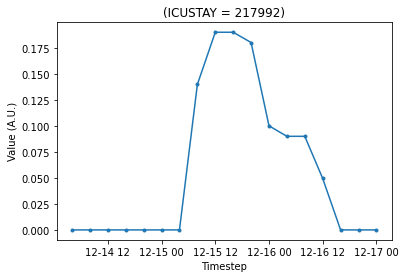

In [9]:
# Example trajectory
icustay_id = random.choice(sampled_vaso_mv_df['icustay_id'].values)
plot(sampled_vaso_mv_df, icustay_id)

### 2. Resampling CareVue records in intervals of 4h

In [10]:
raw_vaso_cv_df = read_csv(DATA_DIR + 'vassopressors_cv_cohort.csv') # Should the same orderid be summed? (part of same solution)
raw_vaso_cv_df.head()

,icustay_id,charttime,rate,rateuom,orderid,linkorderid,vasoactive_drug,mcgkgmin
0,201006,2107-03-24 13:15:00,0.025000,mcgkgmin,2155518,165059,norepinephrine,0.025000
1,201006,2107-03-24 13:30:00,0.045977,mcgkgmin,2155518,165059,norepinephrine,0.045977
2,201006,2107-03-24 14:00:00,0.045977,mcgkgmin,4775458,165059,norepinephrine,0.045977
3,201006,2107-03-24 15:00:00,0.068966,mcgkgmin,890492,165059,norepinephrine,0.068966
4,201006,2107-03-24 16:00:00,0.068966,mcgkgmin,8403974,165059,norepinephrine,0.068966


As can be seen, the CareVue system never registered the interval at which a treatment was delivered, only the `rate` and time at which the rate was set (i.e. the `charttime`). Therefore, the actual time interval (incl. the end time) must be determined from subsequent `charttimes` (of the same `linkorderid`).

In [11]:
# Add interval end as `endtime` (`charttime` is `starttime` of `rate`)
def infer_cv_endtimes(x):
    linkorder_dfs = []
    
    # Find next `charttime` within current drug order
    for linkorderid, linkorder_df in x.groupby('linkorderid'):
        
        # Take next `charttime` as `endtime` of current `rate` within same order
        # TODO fix: `endtime`=`starttime` if `endtime` is not known?
        endtimes = list(linkorder_df['charttime'].values[1:])
        endtimes = endtimes + [endtimes[-1]] if endtimes else endtimes + [np.NaN]
                
        linkorder_df2 = pd.DataFrame({'icustay_id': linkorder_df['icustay_id'].values,
                                      'starttime': linkorder_df['charttime'].values,
                                      'endtime': endtimes,
                                      'mcgkgmin': linkorder_df['mcgkgmin'].values})
        linkorder_dfs.append(linkorder_df2)
        
    return pd.concat(linkorder_dfs)
        
# Add endtimes
vaso_cv_df = raw_vaso_cv_df.groupby('icustay_id').apply(infer_cv_endtimes).reset_index(drop=True)
vaso_cv_df.head()

,icustay_id,starttime,endtime,mcgkgmin
0,201006,2107-03-24 13:15:00,2107-03-24 13:30:00,0.025000
1,201006,2107-03-24 13:30:00,2107-03-24 14:00:00,0.045977
2,201006,2107-03-24 14:00:00,2107-03-24 15:00:00,0.045977
3,201006,2107-03-24 15:00:00,2107-03-24 16:00:00,0.068966
4,201006,2107-03-24 16:00:00,2107-03-24 17:00:00,0.068966


In [12]:
# Store sampled vasopressor sequences as DataFrames in list
sampled_vaso_cv_dfs = []

for icustay_id, treatments in tqdm(vaso_cv_df.groupby('icustay_id')):
        
    # Part of sepsis-3 cohort?
    if icustay_id not in interval_times:
        continue
        
    # Empty vector to store max_vaso values into
    intervals = interval_times[icustay_id]
    max_vaso = np.zeros(len(intervals), dtype=np.float64)
    
    for i, (interval_start, interval_end) in enumerate(intervals):        
        # Inclusion test: treatment timeframe overlaps with current interval.
        # NOTE: original R-code erroneously used `endtime < interval_end`
        condition = (treatments['starttime'] <= interval_end) & (treatments['endtime'] > interval_start)
        
        # Compute max vasopressor dose administered
        max_vaso[i] = treatments[condition]['mcgkgmin'].max() # Why max?
            
    # Create DataFrame
    sampled_vaso_cv_df = pd.DataFrame({'timestep': [end for _, end in intervals],
                                       'icustay_id': icustay_id,
                                       'item_id': 'max_vaso',
                                       'value': np.nan_to_num(max_vaso, nan=0.0)}) # NaN = 0
    sampled_vaso_cv_dfs.append(sampled_vaso_cv_df)
    
    
    
# Concat DataFrames of individual icustays
sampled_vaso_cv_df = pd.concat(sampled_vaso_cv_dfs)
sampled_vaso_cv_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 49.46it/s]


,timestep,icustay_id,item_id,value
0,2107-03-20 21:50:00,201006,max_vaso,0.0
1,2107-03-21 01:50:00,201006,max_vaso,0.0
2,2107-03-21 05:50:00,201006,max_vaso,0.0
3,2107-03-21 09:50:00,201006,max_vaso,0.0
4,2107-03-21 13:50:00,201006,max_vaso,0.0


#### Visual Check

In [13]:
# How many ICU stays recorded vasopressor dose with CareVue?
num_cv_max_vaso_samples = len(set(sampled_vaso_cv_df['icustay_id']))
print('CareVue max_vaso records: %s' % num_cv_max_vaso_samples)

CareVue max_vaso records: 16


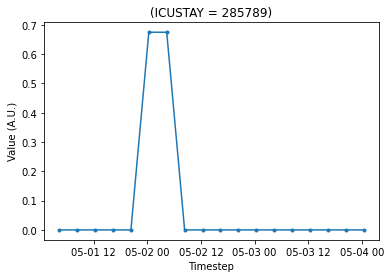

In [14]:
# Example trajectory
icustay_id = random.choice(sampled_vaso_cv_df['icustay_id'].values)
plot(sampled_vaso_cv_df, icustay_id)

---
## IV Fluids

### 1. Resampling MetaVision records in intervals of 4h

In [15]:
ivfluid_mv_df = read_csv(DATA_DIR + 'inputevents_mv_cohort.csv')

# Drop 14-Oral/Gastric Intake (i.e. having a glass of water)
condition = (ivfluid_mv_df['ordercategoryname'] != '14-Oral/Gastric Intake') & (ivfluid_mv_df['amountuom'] == 'ml')
ivfluid_mv_df = ivfluid_mv_df.loc[condition]

# Sanity check: remove amounts outside (0, 5000) range
condition = (ivfluid_mv_df['amount'] > 0) & (ivfluid_mv_df['amount'] < 5000)
ivfluid_mv_df = ivfluid_mv_df.loc[condition]

# Compute duration in hours
# NOTE: original erroneously measured time in minutes
ivfluid_mv_df['duration'] = (ivfluid_mv_df['endtime'] - ivfluid_mv_df['starttime']).astype('timedelta64[s]').astype(int) / 3600

# Drop many useless columns
ivfluid_mv_df = ivfluid_mv_df[['subject_id', 'hadm_id', 'icustay_id', 'starttime', 'endtime', 'amount', 'duration']]
ivfluid_mv_df.head()

,subject_id,hadm_id,icustay_id,starttime,endtime,amount,duration
1,40124,126179,279554,2130-02-04 20:21:00,2130-02-05 04:07:00,999.999978,7.766667
2,40124,126179,279554,2130-02-04 12:36:00,2130-02-04 18:39:00,907.500000,6.050000
4,40124,126179,279554,2130-02-04 14:46:00,2130-02-05 09:01:00,164.299998,18.250000
5,40124,126179,279554,2130-02-05 11:06:00,2130-02-05 15:06:00,499.999992,4.000000
7,40124,126179,279554,2130-02-04 20:21:00,2130-02-05 04:21:00,999.999984,8.000000


In order to determine the total amount of IV fluid administered within a 4 hour interval, we need to calculate how long a treatment was administered for during an interval; multiplied by the rate (i.e. `amount / duration`) we can infer the total amount administered by each treatment during the current interval. For this we use the `total_admin_in_interval` function below:

In [16]:
# Computes how much of each dose was administered between interval_start and interval_end
def total_admin_in_interval(interval_start, interval_end, treatments):
    dose_start = treatments['starttime']
    dose_end = treatments['endtime']
    amount = treatments['amount']
    duration = treatments['duration']
    rate = amount / duration # in ml/hour!   
    
    total_ml = 0
    
    # Option 1: Dose started before interval and ended after interval
    c1 = (dose_start < interval_start) & (dose_end > interval_end)
    if c1.any():
        total_ml += (to_hours(interval_end - interval_start) * rate[c1]).sum()
    
    # Option 2: Dose started before and ended within interval
    c2 = (dose_start < interval_start) & (dose_end > interval_start) & (dose_end <= interval_end)
    if c2.any():
        total_ml += (to_hours(dose_end - interval_start) * rate[c2]).sum()
    
    # Option 3: Dose started and ended in interval
    c3 = (dose_start >= interval_start) & (dose_start < interval_end) & (dose_end <= interval_end) & (dose_end > interval_start)
    if c3.any():
        total_ml += amount[c3].sum()
    
    # Option 4: dose started in interval and ended after interval
    c4 = (dose_start >= interval_start) & (dose_start < interval_end) & (interval_end < dose_end)
    if c4.any():
        total_ml += (to_hours(interval_end - dose_start) * rate[c4]).sum()
            
    return total_ml

We can now use `total_admin_in_interval()` on each interval `(interval_start, interval_end)` and treatment in `ivfluid_mv_df` to compute the total IV fluid administration within each 4 hour interval:

In [17]:
# Store sampled dfs in list
sampled_ivfluid_mv_dfs = []

print('Grab some coffee!\n')

for icustay_id, treatments in tqdm(ivfluid_mv_df.groupby('icustay_id')):
    
    # Is icustay part of cohort?
    if icustay_id not in interval_times:
        continue
    
    # Total fluid intake
    intervals = interval_times[icustay_id]
    total_ivfluid = np.zeros(len(intervals), dtype=np.float64)
    
    for i, (interval_start, interval_end) in enumerate(intervals):
                
        # Compute total IV fluid
        total_ivfluid[i] = total_admin_in_interval(interval_start, interval_end, treatments)
                
    # Create DataFrame
    sampled_ivfluid_df = pd.DataFrame({'icustay_id': icustay_id,
                                       'timestep': [end for _, end in intervals],
                                       'item_id': 'total_iv_fluid',
                                       'value': np.nan_to_num(total_ivfluid, nan=0.0)}) # NaN = 0
    sampled_ivfluid_mv_dfs.append(sampled_ivfluid_df)
    
# Concat DataFrames of individual icustays
sampled_ivfluid_mv_df = pd.concat(sampled_ivfluid_mv_dfs)
sampled_ivfluid_mv_df.head()

Grab some coffee!



100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:02<00:00, 25.49it/s]


,icustay_id,timestep,item_id,value
0,201204,2121-12-07 03:00:00,total_iv_fluid,0.0
1,201204,2121-12-07 07:00:00,total_iv_fluid,0.0
2,201204,2121-12-07 11:00:00,total_iv_fluid,0.0
3,201204,2121-12-07 15:00:00,total_iv_fluid,0.0
4,201204,2121-12-07 19:00:00,total_iv_fluid,0.0


#### Visual check

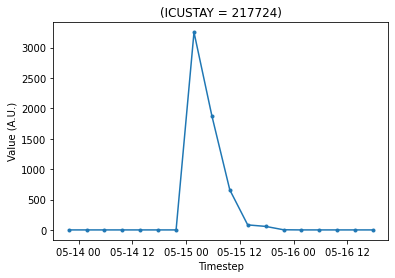

In [18]:
# Get total IV fluid intake for one random patient
icustay_id = random.choice(sampled_ivfluid_mv_df['icustay_id'].values)
plot(sampled_ivfluid_mv_df, icustay_id)

### 1. Resampling CareVue records in intervals of 4h
**Problem:** Cannot be done as no end-of-interval points can be derived (?)

---
## Vitals

Vitals are already in the correct general formal, therefore we only need to rename the columns, drop unnecessary ones and snake-case the `item_ids`;

In [19]:
vitals_df = read_csv(DATA_DIR + 'vitals_cohort.csv')

# Simply rename columns (vitals_df is already in the right format)
new_vitals_df = pd.DataFrame({'icustay_id': vitals_df['icustay_id'],
                              'timestep': vitals_df['charttime'],
                              'item_id': vitals_df['vital_id'].apply(to_snakecase),
                              'value': vitals_df['valuenum']})
new_vitals_df.head()

,icustay_id,timestep,item_id,value
0,206504,2164-10-23 22:40:00,dias_bp,50.000000
1,206504,2164-10-23 22:40:00,heart_rate,104.000000
2,206504,2164-10-23 22:40:00,mean_bp,63.666698
3,206504,2164-10-23 22:40:00,resp_rate,25.000000
4,206504,2164-10-23 22:40:00,sp_o2,98.000000


---
## Lab Results

In [20]:
lab_df = read_csv(DATA_DIR + 'labs_cohort.csv')

# Drop NaNs in lab_id column
lab_df = lab_df[lab_df['lab_id'].notna()]

# Simply rename columns (lab_df is already in the right format)
new_lab_df = pd.DataFrame({'icustay_id': lab_df['icustay_id'],
                           'timestep': lab_df['charttime'],
                           'item_id': lab_df['lab_id'].apply(to_snakecase),
                           'value': lab_df['valuenum']})
new_lab_df.head()

,icustay_id,timestep,item_id,value
0,206504,2164-10-23 17:33:00,lactate,4.4
1,206504,2164-10-23 17:38:00,alat,9.0
2,206504,2164-10-23 17:38:00,albumin,3.4
3,206504,2164-10-23 17:38:00,anion gap,20.0
4,206504,2164-10-23 17:38:00,asat,40.0


---
## FiO2 (Fraction of Inspired Oxygen)

In [21]:
fio2_df = read_csv(DATA_DIR + 'fio2_cohort.csv')

new_fio2_df = pd.DataFrame({'icustay_id': fio2_df['icustay_id'],
                            'timestep': fio2_df['charttime'],
                            'item_id': 'fi_o2',
                            'value': fio2_df['fio2']})
new_fio2_df.head()

,icustay_id,timestep,item_id,value
0,264446,2125-10-05 00:00:00,fi_o2,60.000002
1,264446,2125-10-05 01:00:00,fi_o2,40.000001
2,264446,2125-10-05 03:00:00,fi_o2,40.000001
3,264446,2125-10-05 07:00:00,fi_o2,69.999999
4,264446,2125-10-05 10:00:00,fi_o2,69.999999


---
## Urine Output

In [22]:
urineoutput_df = read_csv(DATA_DIR + 'urineoutput_cohort.csv')

new_urineoutput_df = pd.DataFrame({'icustay_id': urineoutput_df['icustay_id'],
                                   'timestep': urineoutput_df['charttime'],
                                   'item_id': 'urine_output',
                                   'value': urineoutput_df['value']})
new_urineoutput_df.head()

,icustay_id,timestep,item_id,value
0,201204,2121-12-08 17:00:00,urine_output,40
1,201204,2121-12-08 22:00:00,urine_output,40
2,201204,2121-12-09 07:00:00,urine_output,25
3,201204,2121-12-07 22:00:00,urine_output,30
4,201204,2121-12-08 00:12:00,urine_output,30


---
## Demographics

In [23]:
USED_DEMOGRAPHICS = ['age', 'height', 'is_male', 'weight', 'vent', 'sofa', 'sirs']

In [24]:
demo_df = read_csv(DATA_DIR + 'demographics_cohort.csv')[['icustay_id'] + USED_DEMOGRAPHICS]
demo_df.head() 

,icustay_id,age,height,is_male,weight,vent,sofa,sirs
0,206504,70.6354,NaN,0,NaN,0,6,2
1,264446,87.0847,165.10,0,95.0,1,7,4
2,204881,73.6772,NaN,0,NaN,0,2,4
3,228977,48.8991,180.34,1,105.3,1,19,4
4,277021,91.4000,NaN,0,NaN,0,2,2


---
## Discretize Action Space

In [25]:
# Use pre-estimated action space bins
max_vaso_bins = np.loadtxt('max_vaso_bins.npy')
print('Max vasopressor bins:')
print(max_vaso_bins, '\n')

total_iv_fluid_bins = np.loadtxt('total_iv_fluid_bins.npy')
print('IV fluid bins:')
print(total_iv_fluid_bins)

Max vasopressor bins:
[0.         0.0494738  0.07996948 0.16012785 0.24798583 1.41302172] 

IV fluid bins:
[0.00000000e+00 2.42013560e+00 1.85161696e+02 4.90117350e+02
 9.41210943e+02 7.22415002e+03]


In [26]:
def discretize_and_shift_action(max_vaso_df, iv_fluid_df, max_vaso_bins, iv_fluid_bins):
    # Store discretized actions [0-24] as novel 'measurements'
    action_dfs = []
    
    # Merge vasopressor and IV fluid DataFrames
    action_space_df = pd.concat([max_vaso_df, iv_fluid_df])

    # Process vassopressor and IV-fluids of ICU-stays one-by-one
    for icustay_id, measurements in tqdm(action_space_df.groupby('icustay_id')):
        
        max_vaso = measurements[measurements['item_id'] == 'max_vaso']        
        iv_fluid = measurements[measurements['item_id'] == 'total_iv_fluid']
        
        # If no vasopressors or IV fluids were recorded, use zeros instead
        timesteps = [end for _, end in interval_times[icustay_id]]
        if len(max_vaso) == 0:
            max_vaso = pd.DataFrame({'timestep': timesteps, 'icustay_id': icustay_id,
                                     'item_id': 'max_vaso', 'value': 0})
        if len(iv_fluid) == 0:
            iv_fluid = pd.DataFrame({'timestep': timesteps, 'icustay_id': icustay_id,
                                     'item_id': 'total_iv_fluid', 'value': 0})

        # Discretzie both actions 0 to 4
        max_vaso_discrete = pd.cut(max_vaso['value'], 
                                   bins=max_vaso_bins, 
                                   labels=[0, 1, 2, 3, 4], 
                                   include_lowest=True).astype(float)

        iv_fluid_discrete = pd.cut(iv_fluid['value'], 
                                   bins=iv_fluid_bins, 
                                   labels=[0, 1, 2, 3, 4], 
                                   include_lowest=True).astype(float)

        # Compute action index in 0 to 24
        discrete_actions = 5 * iv_fluid_discrete + max_vaso_discrete

        # Shift actions back in time by one step (as we want to predict next action)
        timesteps = timesteps[1:]
        discrete_actions = discrete_actions.values[1:]

        # Merge into DataFrame
        action_df = pd.DataFrame({'timestep': timesteps,
                                  'icustay_id': icustay_id,
                                  'item_id': 'action',
                                  'value': discrete_actions})
        action_dfs.append(action_df)

    # Concat DataFrames of individual icustays
    action_dfs = pd.concat(action_dfs)
    return action_dfs


action_df = discretize_and_shift_action(sampled_vaso_mv_df, sampled_ivfluid_mv_df, max_vaso_bins, total_iv_fluid_bins)
action_df.head()

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 129.56it/s]


,timestep,icustay_id,item_id,value
0,2121-12-07 07:00:00,201204,action,0.0
1,2121-12-07 11:00:00,201204,action,0.0
2,2121-12-07 15:00:00,201204,action,0.0
3,2121-12-07 19:00:00,201204,action,0.0
4,2121-12-07 23:00:00,201204,action,20.0


### Visual Check

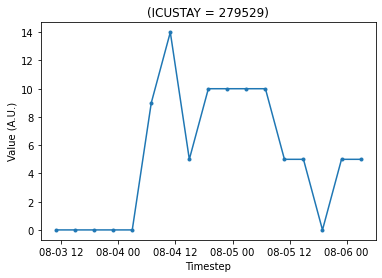

In [27]:
icustay_id = random.choice(action_df['icustay_id'].values)
plot(action_df, icustay_id)

---
## Putting it all Together

In [28]:
# Merge measurement DataFrames (skip demographics!)
full_df = pd.concat([sampled_vaso_mv_df,
                     #sampled_vaso_cv_df, # Do we use CareVue?
                     sampled_ivfluid_mv_df, 
                     new_vitals_df, 
                     new_lab_df, 
                     new_fio2_df, 
                     new_urineoutput_df,
                     action_df]).dropna(axis=0).reset_index(drop=True)

# Group ICU-stays and by increasing timestep
full_df = full_df.sort_values(by=['icustay_id', 'timestep']).reset_index(drop=True)
full_df.head(20)

,timestep,icustay_id,item_id,value
0,2107-03-22 06:10:00,201006,alat,37.0
1,2107-03-22 06:10:00,201006,anion gap,14.0
2,2107-03-22 06:10:00,201006,asat,40.0
3,2107-03-22 06:10:00,201006,bands,1.0
4,2107-03-22 06:10:00,201006,bicarbonate,23.0
5,2107-03-22 06:10:00,201006,bilirubin,0.9
6,2107-03-22 06:10:00,201006,bun,16.0
7,2107-03-22 06:10:00,201006,calcium,7.7
8,2107-03-22 06:10:00,201006,chloride,103.0
9,2107-03-22 06:10:00,201006,creatinine,0.8


### Expected Memory Usage

In [29]:
# Size of current dataset with current ICU stays
full_df_gigs = full_df.memory_usage(deep=True).sum() / (1 << 30)
num_icustay_ids = len(set(full_df['icustay_id']))
print('Number of ICU-stay ids:', num_icustay_ids)

# Expected GB of whole 40.000 ICU stays in MIMIC-III
exp_gigs = 40000 * full_df_gigs / num_icustay_ids

print('Expected memory usage of dataset: %sGB' % round(exp_gigs, 2)) 

Number of ICU-stay ids: 59
Expected memory usage of dataset: 1.39GB


---
## Train/Valid/Test Split
We will use the dataset split created in `MIMIC-III_preprocessing_handcrafted_v4.ipynb` to allow a fair comparison between models;

In [30]:
train_icustay_ids = np.loadtxt('mimic-iii_icustay_ids_train.npy')
valid_icustay_ids = np.loadtxt('mimic-iii_icustay_ids_valid.npy')
test_icustay_ids = np.loadtxt('mimic-iii_icustay_ids_test.npy')

# Timestamped measurements, e.g. vitals, lab results, vasopressor/IV-fluid doses, etc.
train_df = full_df[full_df['icustay_id'].isin(train_icustay_ids)].copy() # to prevent warnings
valid_df = full_df[full_df['icustay_id'].isin(valid_icustay_ids)].copy()
test_df = full_df[full_df['icustay_id'].isin(test_icustay_ids)].copy()

# Demographics, e.g., age, weight, SOFA scores
train_demo_df = demo_df[demo_df['icustay_id'].isin(train_icustay_ids)].copy()
valid_demo_df = demo_df[demo_df['icustay_id'].isin(valid_icustay_ids)].copy()
test_demo_df = demo_df[demo_df['icustay_id'].isin(test_icustay_ids)].copy()
print('Done!')

Done!


---
## Feature scaling: "zero mean 'n unit variance"

### 1. Timestamped measurements

In [32]:
# Compute averages and stdevs over measurements in training set with same item_id (e.g. 'heart_rate')
item_avg = train_df.groupby('item_id')['value'].mean(numeric_only=True).to_dict()
item_std = train_df.groupby('item_id')['value'].std().to_dict()

# Prevents action from being scaled
item_avg['action'] = 0
item_std['action'] = 1

In [33]:
def scale_features_by_item(values):
    item_id = values.name
    return (values - item_avg[item_id]) / item_std[item_id]

# Scale measurements
train_df['value'] = train_df.groupby('item_id')['value'].transform(scale_features_by_item)
valid_df['value'] = valid_df.groupby('item_id')['value'].transform(scale_features_by_item)
test_df['value'] = test_df.groupby('item_id')['value'].transform(scale_features_by_item)
print('Done!')

Done!


In [34]:
# Visual check
pd.DataFrame({'avg.': train_df.groupby('item_id')['value'].mean().round(3), 
              'std.': train_df.groupby('item_id')['value'].std().round(3)}).T

item_id,action,alat,albumin,anion gap,asat,bands,base_excess,bicarbonate,bilirubin,bun,...,pt,ptt,resp_rate,sodium,sp_o2,sys_bp,temp_c,total_iv_fluid,urine_output,wbc
avg.,5.634,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,...,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
std.,7.251,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### 2. Demographics

In [35]:
# Compute averages and stdevs over columns of measurements in training set (e.g. 'age')
demo_avg = train_demo_df[USED_DEMOGRAPHICS].mean(axis=0)
demo_std = train_demo_df[USED_DEMOGRAPHICS].std(axis=0)

# Use estimates to scale train, validation and test sets
for col in USED_DEMOGRAPHICS:
    train_demo_df[col] = (train_demo_df[col] - demo_avg[col]) / demo_std[col]
    valid_demo_df[col] = (valid_demo_df[col] - demo_avg[col]) / demo_std[col]
    test_demo_df[col] = (test_demo_df[col] - demo_avg[col]) / demo_std[col]

In [36]:
# Visual check
pd.DataFrame({'avg.': train_demo_df[USED_DEMOGRAPHICS].mean(axis=0), 
              'std.': train_demo_df[USED_DEMOGRAPHICS].std(axis=0)}).T

,age,height,is_male,weight,vent,sofa,sirs
avg.,-1.004487e-16,2.203366e-15,-6.344132e-17,-5.653373e-16,6.344132e-17,1.163091e-16,6.079793e-17
std.,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### Export Datasets

In [37]:
# Save training, validation and test sets
train_df.to_csv('mimic-iii_train_no-binning.csv')
valid_df.to_csv('mimic-iii_valid_no-binning.csv')
test_df.to_csv('mimic-iii_test_no-binning.csv')

# Save demographics
train_demo_df.to_csv('mimic-iii_train_no-binning_demographics.csv')
valid_demo_df.to_csv('mimic-iii_valid_no-binning_demographics.csv')
test_demo_df.to_csv('mimic-iii_test_no-binning_demographics.csv')

---
## Let's Visualize!

Messy as expected...

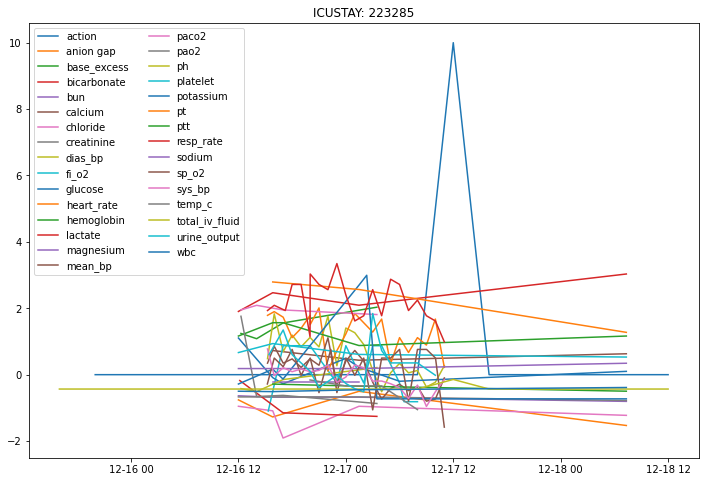

In [38]:
icustay_id = random.choice(train_df['icustay_id'].values)
icustay_df = train_df[train_df['icustay_id'] == icustay_id]

plt.figure(figsize=(12, 8))

for item_id, item_df in icustay_df.groupby('item_id'):
    plt.plot(item_df['timestep'], item_df['value'], label=item_id)
    
plt.title('ICUSTAY: %s' % icustay_id)
plt.legend(ncol=2)
plt.show()